# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

Имеются данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных проводилась ранее.
Необходимо построить модель с максимально большим значением accuracy, довести долю правильных ответов по крайней мере до 0.75, проверить accuracy на тестовой выборке.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Библиотеки" data-toc-modified-id="Библиотеки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Библиотеки</a></span></li><li><span><a href="#Загрузка-датасета,-разделение-данных" data-toc-modified-id="Загрузка-датасета,-разделение-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка датасета, разделение данных</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование моделей</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Решающие-деревья" data-toc-modified-id="Решающие-деревья-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Решающие деревья</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Случайный-лес-с-градиентным-усилением" data-toc-modified-id="Случайный-лес-с-градиентным-усилением-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Случайный лес с градиентным усилением</a></span></li></ul></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></div>

## Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Библиотеки

In [1]:
# для вывода
from IPython.display import Markdown, display 
from tqdm.notebook import tqdm_notebook as tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# для работы с данными
import pandas as pd
import numpy as np

# для обучения
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

# для графиков
from matplotlib import pyplot as plt
import seaborn as sns
# настройки
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6

# константы
RANDOM_STATE = 123

## Загрузка датасета, разделение данных

Загрузим датасет, изучим данные

In [2]:
df = pd.read_csv('../datasets/users_behavior.csv')
print('Размер датасета:', df.shape)
display(Markdown('**Smart**'), df[~df.is_ultra.astype('bool')].describe())
display(Markdown('**Ultra**'), df[df.is_ultra.astype('bool')].describe())

Размер датасета: (3214, 5)


**Smart**

,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


**Ultra**

,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


Датасет имеет 4 количественных признака и один категориальный целевой признак, который делит все объекты на 2 класса.
Таким образом, решаем задачу бинарной классификации. 

Объектов класса `is_ultra=1` значительно меньше (примерно в 2.5 раза).  

Посмотрим на распределения всех признаков для обоих тарифов и коэффициенты корелляции

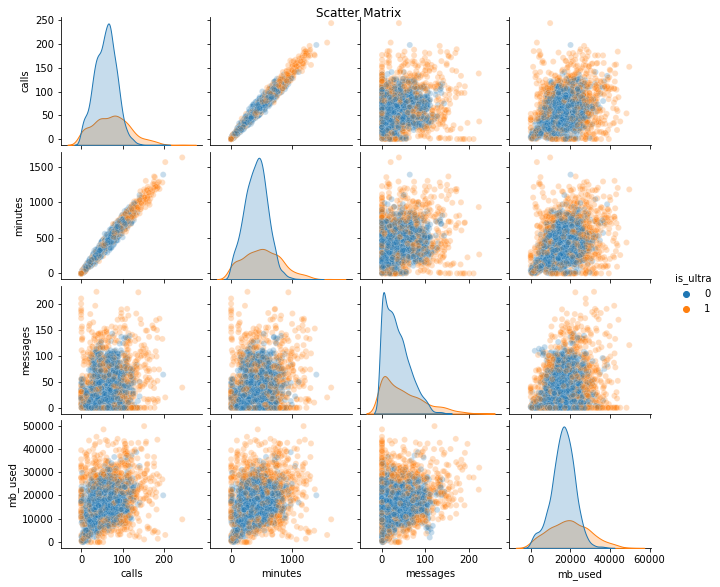

In [3]:
(sns.pairplot(df, vars = df.columns[:-1], hue='is_ultra', plot_kws=dict(alpha=0.25))
    .fig.set_size_inches(10,8) );
plt.suptitle('Scatter Matrix', y=1.);

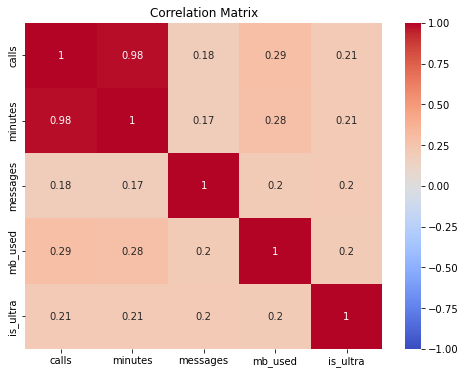

In [4]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);
plt.title('Correlation Matrix');

Коэффициент корреляции между значениями `calls` и `minutes` очень близок к единице, что свидетельствует о линейной зависимсоти между ними, она наблюдается и на матрице рассеяния. Также формы распределений этих признаков от других практически повторяют друг друга. Один из столбцов можно отбросить. Поскольцу стоимость услуг связи определяется количеством минут, а не количеством звонков, то не будем включать в модель столбец `calls`. 

Отделим признаки метки, разобъём выборку на тренировочную, валидационную и тестовую в соотношении __3 : 1 : 1__

In [5]:
def display_shape(X,y,str_to_print):
    display(Markdown('**'+str_to_print+'** Признаки: {}, Метки: {}'.format(X.shape, y.shape)))

X = df.drop(['calls','is_ultra'], axis=1)
y = df['is_ultra']

X_train, X_test, y_train, y_test = (
    train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE) )

X_train, X_val, y_train, y_val = ( # 0.25 x 0.8 = 0.2
    train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE) )

display_shape(X,y,'Размер выборок до разделения:')
display_shape(X_train,y_train,'Тренировочная:')
display_shape(X_val,y_val,'Валидационная:')
display_shape(X_test,y_test,'Тестовая:')

**Размер выборок до разделения:** Признаки: (3214, 3), Метки: (3214,)

**Тренировочная:** Признаки: (1928, 3), Метки: (1928,)

**Валидационная:** Признаки: (643, 3), Метки: (643,)

**Тестовая:** Признаки: (643, 3), Метки: (643,)

## Исследование моделей

### Логистическая регрессия

Обучим модель логистической регрессии на тренировочной выборке и оценим точность предсказаний на валидационной и тестовой выборках

In [6]:
model = LogisticRegression(random_state=RANDOM_STATE)
start = time.time()             # время начала
model.fit(X_train, y_train)     # обучение модели
fit_time = time.time() - start  # время обучения
# вычисляем правильность
score_val = model.score(X_val, y_val)
score_test = model.score(X_test, y_test) 
display(Markdown('**Логистическая регрессия** (LogisticRegression).<br><br>\
    Время обучения = {:.3f}   сек. <br>_Точность предсказания_:<br>\
    Валидационная выборка = {:.4f},<br> Тестовая выборка = {:.4f}'
    .format(fit_time, score_val, score_test)))

**Логистическая регрессия** (LogisticRegression).<br><br>    Время обучения = 0.012   сек. <br>_Точность предсказания_:<br>    Валидационная выборка = 0.7061,<br> Тестовая выборка = 0.7107

Недолгое время обучения, Accuracy на валидационной выборке немного меньше, чем на тестовой. Скорее всего переобучения нет, но точность невысокая.  

### Решающие деревья

Обучим решающие деревья с разной глубиной `depth` от 1 до 12, для каждой модели оценим время обучения и точность предсказания на валидационной и тестовой выборках, для удобства выведем на графике

**Классификатор дерева решений** (DecisionTreeClassifier)

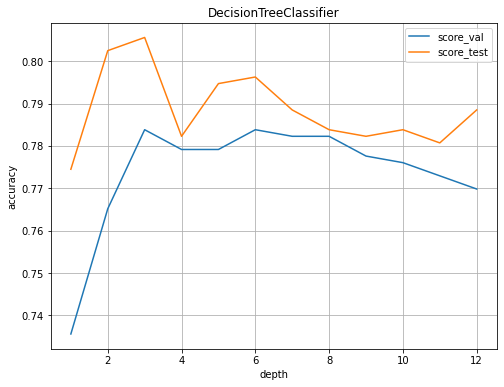

,depth,fit_time,score_val,score_test
2,3,0.002996,0.783826,0.805599
5,6,0.003001,0.783826,0.796267
6,7,0.003998,0.782271,0.788491
7,8,0.004001,0.782271,0.783826
3,4,0.003000,0.779160,0.782271
4,5,0.002998,0.779160,0.794712
8,9,0.003999,0.777605,0.782271
9,10,0.005004,0.776050,0.783826
10,11,0.005002,0.772939,0.780715
11,12,0.005000,0.769829,0.788491


In [7]:
display(Markdown('**Классификатор дерева решений** (DecisionTreeClassifier)'))

# таблица с метриками Accuracy и временем выполнения алгоритма
tree_stat = pd.DataFrame(columns=['depth','fit_time','score_val','score_test'])

# цикл алгоритма обучения
for dep in range(1,13):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=dep)
    start = time.time()            
    model.fit(X_train, y_train)
    fit_time = time.time() - start 
    # записываем Accuracy на валидационной и тестовой выборке
    score_val = model.score(X_val, y_val)
    score_test = model.score(X_test, y_test)
    # записываем пезультаты в таблицу
    tree_stat = tree_stat.append(
        {'depth':dep, 'fit_time':fit_time, 'score_val':score_val, 'score_test':score_test}, 
        ignore_index=True)

# выводим график Accuracy 
tree_stat['depth'] = tree_stat['depth'].astype('int')
tree_stat.plot( x='depth', y=['score_val','score_test'], grid=True, figsize=(8,6),
    ylabel='accuracy', title='DecisionTreeClassifier')
plt.show()
# выводим таблицу, отсортированную по Accuracy
tree_stat = tree_stat.sort_values(by='score_val', ascending=False)
tree_stat


По диаграмме видим, что деревья с маленькой глубиной склонны к недообучению.

Наилучшую точность предсказаний показали, деревья с глубиной 3. Выше значения 8 точность становится хуже

Время обучения для модели дерева решения во всех случаях оказалось меньше, чем для Линейной регресии

### Случайный лес

Аналогично обучим модели случайного леса с разным количеством деревьев и глубиной, выведем для сравнения точности её зависимости от количества деревьев `n_estimators` для разной глубины `depth` и наоборот. Для вывода графиков реализуем вспомогательную функцию

In [8]:
def show_accuracy_plots(stat_table, classifier):
    '''Отображение графиков зависимости Accuracy на валидационной и тестовой выборках для модели случайного леса 
        
       stat_table : таблица с accuracy
       classifier : имя классификатора
    '''
    ylim = (0.99*stat_table[['score_val','score_test']].min().round(2).min(),
            1.01*stat_table[['score_val','score_test']].max().round(2).max())
    _, ax =plt.subplots(1,2,figsize=(13,6))
    sns.pointplot(data=stat_table, x='depth', y='score_val', hue='n_estimators', ax=ax[0])
    sns.pointplot(data=stat_table, x='depth', y='score_test', hue='n_estimators', ax=ax[1])
    ax[0].grid(), ax[0].set(ylim=ylim, title='Validate Accuracy')
    ax[1].grid(), ax[1].set(ylim=ylim, title='Test Accuracy')
    plt.suptitle(classifier+' (depth)');
    plt.show()
    _, ax =plt.subplots(1,2,figsize=(13,6))
    sns.pointplot(data=stat_table, x='n_estimators', y='score_val', hue='depth', ax=ax[0])
    sns.pointplot(data=stat_table, x='n_estimators', y='score_test', hue='depth', ax=ax[1])
    ax[0].grid(), ax[0].set(ylim=ylim, title='Validate Accuracy')
    ax[1].grid(), ax[1].set(ylim=ylim, title='Test Accuracy')
    plt.suptitle(classifier+' (n_estimators)');
    plt.show()

**Классификатор случайного леса** (RandomForestClassifier)

  0%|          | 0/10 [00:00<?, ?it/s]

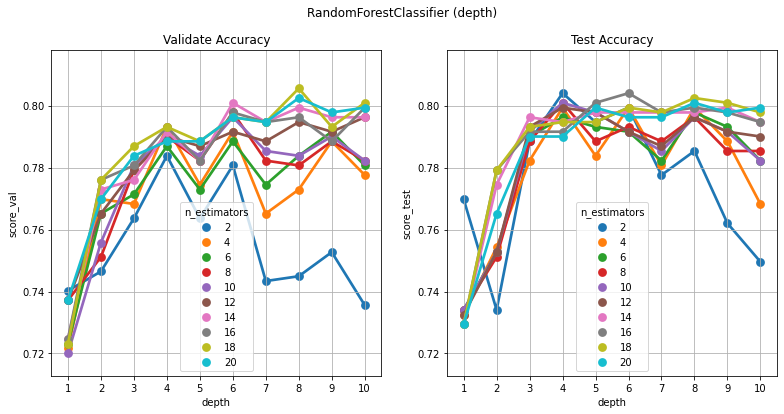

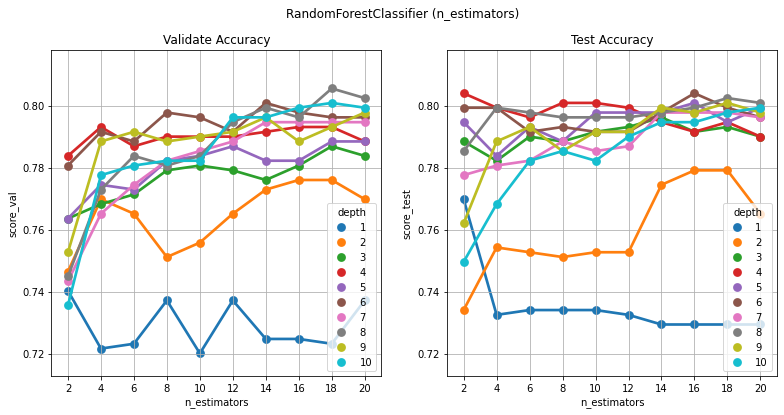

,n_estimators,depth,fit_time,score_val,score_test
87,18,8,0.031002,0.805599,0.802488
97,20,8,0.033998,0.802488,0.800933
89,18,10,0.033998,0.800933,0.797823
65,14,6,0.023000,0.800933,0.797823
99,20,10,0.035999,0.799378,0.799378
67,14,8,0.024003,0.799378,0.797823
79,16,10,0.030001,0.799378,0.794712
98,20,9,0.035002,0.797823,0.797823
75,16,6,0.025001,0.797823,0.804044
35,8,6,0.014002,0.797823,0.793157


In [9]:
display(Markdown('**Классификатор случайного леса** (RandomForestClassifier)'))
# таблица с метриками Accuracy и временем выполнения алгоритма
forest_stat = pd.DataFrame(
    columns=['n_estimators','depth','fit_time','score_val','score_test'])
# цикл алгоритма обучения
for est in tqdm(range(2, 21, 2)):
    for dep in range(1,11):
        model = RandomForestClassifier(
            random_state=RANDOM_STATE, n_estimators=est, max_depth=dep) 
        start = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start 
        score_val = model.score(X_val, y_val)
        score_test = model.score(X_test, y_test)
        forest_stat = forest_stat.append({
            'n_estimators':est, 'depth':dep, 'fit_time':fit_time, 
            'score_val':score_val, 'score_test':score_test}, ignore_index=True)

# вывод статистики
forest_stat[['n_estimators','depth']] = forest_stat[['n_estimators','depth']].astype('int')
show_accuracy_plots(forest_stat, 'RandomForestClassifier')
forest_stat = forest_stat.sort_values(by='score_val', ascending=False)
forest_stat.head(10)

Лес с глубиной до 2 склонен к недообучению. С увеличением глубины до значения 8 точность предсказаний на валидационной выборке растёт для числа деревьев больее 6, затем ухудшается.

- Лучшую точность на валидационной выборке показала модель с глубиной 8 и числом деревьев 18 
- Некоторые модели показали на тестовой выборке меньшую точность, это признак переобучения
- Модели с бОльшим числом деревьев (> 8) и достаточной глубиной (> 4) показали на тестовой выборке большую точность, чем на валидационной

### Случайный лес с градиентным усилением

Аналогично проанализируем модели случайного леса градиентным усилением. Также посмотрим на зависимость точности от разного количества деревьев и глубины. На самом деле они имеет больше разных гиперпараметров, в том числе скорость обучения. Но пока с равним только глубину и число деревьев.

**Деревья с градиентным усилением** (XGBClassifier)

  0%|          | 0/10 [00:00<?, ?it/s]

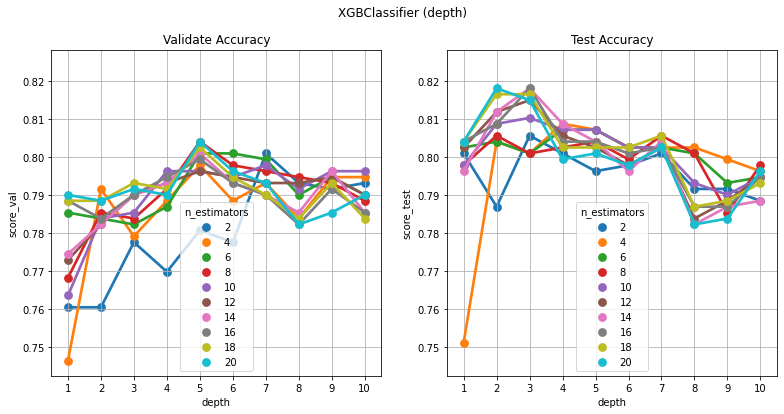

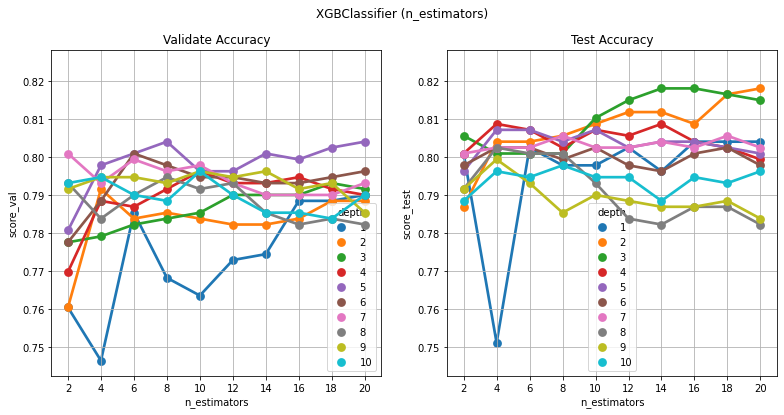

,n_estimators,depth,fit_time,score_val,score_test
34,8,5,0.014000,0.804044,0.804044
94,20,5,0.024001,0.804044,0.800933
84,18,5,0.022000,0.802488,0.802488
24,6,5,0.011002,0.800933,0.807154
25,6,6,0.012001,0.800933,0.802488
6,2,7,0.008000,0.800933,0.800933
64,14,5,0.019002,0.800933,0.804044
26,6,7,0.013998,0.799378,0.802488
74,16,5,0.021000,0.799378,0.804044
14,4,5,0.009002,0.797823,0.807154


In [10]:
#%%capture --no-display
display(Markdown('**Деревья с градиентным усилением** (XGBClassifier)'))

xgb_stat = pd.DataFrame(
    columns=['n_estimators','depth','fit_time','score_val','score_test'])
for est in tqdm(range(2, 21, 2)):
    for dep in range(1,11):
        model = XGBClassifier(n_estimators=est, max_depth=dep, eval_metric = 'error', 
                              random_state=RANDOM_STATE, use_label_encoder=False) 
        start = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start 
        score_val = model.score(X_val, y_val)
        score_test = model.score(X_test, y_test)
        xgb_stat = xgb_stat.append({
            'n_estimators':est, 'depth':dep, 'fit_time':fit_time, 
            'score_val':score_val, 'score_test':score_test}, ignore_index=True)

xgb_stat[['n_estimators','depth']] = xgb_stat[['n_estimators','depth']].astype('int')

show_accuracy_plots(xgb_stat, 'XGBClassifier')

xgb_stat = xgb_stat.sort_values(by='score_val', ascending=False)
xgb_stat.head(10)

`XGBClassifier` обучается по времени примерно столько же, сколько и `RandomForestClassifier`.

- Судя по результатам точности предсказаний на валидационной выбоке модели с количеством деревьев до 4 хуже обучаются практически при любой глубине. Аналогично модели с глубиной до 4 - при любом количестве деревьев. В то же время при большом количестве деревьев (20) и глубине 2 наилучшая Accuracy на тестовой выборке
- На валидационной выборке лучше всего сработали модели с глубиной от 5 и количеством деревьев от 10
- Примечательно, что в целом для моделей с глубиной от 2 до 5 точность на тестовой выборке выше, чем на валидационной.

Посмотрим также как влияет на результаты предсказаний `XGBClassifier` изменение скорости обучения `learning_rate`. Она может изменяться от 0 до 1. Обучим с разной скоростью обучения модель с `n_estimators = 20` и  `depth = 5`


**Деревья с градиентным усилением** (XGBClassifier)

  0%|          | 0/100 [00:00<?, ?it/s]

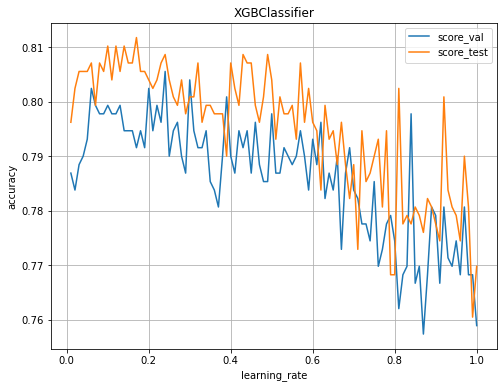

In [11]:
display(Markdown('**Деревья с градиентным усилением** (XGBClassifier)'))

xgb_stat_lr = pd.DataFrame(columns=['learning_rate','fit_time','score_val','score_test'])

for lr in tqdm(np.linspace(0.01, 1.00, 100)):
    model = XGBClassifier(n_estimators=20, max_depth=5, eval_metric = 'error', 
                          random_state=RANDOM_STATE, use_label_encoder=False, learning_rate=lr) 
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start 
    score_val = model.score(X_val, y_val)
    score_test = model.score(X_test, y_test)
    xgb_stat_lr = xgb_stat_lr.append({
        'learning_rate':lr, 'fit_time':fit_time, 
        'score_val':score_val, 'score_test':score_test}, ignore_index=True)

# выводим график Accuracy 
xgb_stat_lr.plot( x='learning_rate', y=['score_val','score_test'], grid=True, figsize=(8,6),
    ylabel='accuracy', title='XGBClassifier')
plt.show()

При значениях скорости обучения выше 0.4 точность падает как на валидационной, так и на тестовых выборках.

Однако слишком маленькие значения тоже не стоит использовать - точность предсказаний на валидационной выборке меньше, чем на тестовой и в целом при значении в районе 0.3 (это значение по умолчанию) классификатор показывает лучшую точность. 

## Проверка на адекватность

Проверим модели случайного леса `RandomForestClassifier` и `XGBClassifier`, которые показали наилучшие Accuracy на валидациолнной выборке на вменяемость

Используем значения включённых в тариф пакетов:
- в _Smart_ включено 500 минут, 50 сообщений и 15 Гб
- в _Ultra_ включено 3000 минут, 1000 сообщений и 30 Гб

Сгенерируем две выборки признаков из случайных значений:
- `X_sanity_smart` - в котором значения не будут превышать тех, которые включены в пакеты для тарифа _Smart_.
- `X_sanity_ultra` - в котором значения будут превышать те, которые включены в пакеты для тарифа _Smart_.

Таким образом, первый набор должен быть отнесён к классу `is_ultra=0`, второй `is_ultra=1`.

Количество звонков определим как количество минут делённое на среднюю продолжительность звонка, поскольку зависимость между ними практически линейная

In [12]:
# средняя продолжительность звонка
call_diration = df.minutes.mean() / df.calls.mean()
# размер выборок для теста
size = 100
# выборка smart
X_sanity_smart = pd.DataFrame({
	'minutes': np.random.randint(0,500,size=size),	
    'messages': np.random.randint(0,50,size=size),	
    'mb_used': np.random.randint(0,15360,size=size)})
# выборка ultra
X_sanity_ultra = pd.DataFrame({
	'minutes': np.random.randint(501,2000,size=size),	
    'messages': np.random.randint(51,250,size=size),	
    'mb_used': np.random.randint(15361,60000,size=size)})

In [13]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, 
                                  n_estimators=18, max_depth=8)
model_rf.fit(X_train, y_train)
pred_rf_ultra = model_rf.predict(X_sanity_ultra)
pred_rf_smart = model_rf.predict(X_sanity_smart)

model_xgb = XGBClassifier(n_estimators=20, max_depth=5, eval_metric = 'error',
                          random_state=RANDOM_STATE, use_label_encoder=False)
model_xgb.fit(X_train, y_train)
pred_xgb_ultra = model_xgb.predict(X_sanity_ultra)
pred_xgb_smart = model_xgb.predict(X_sanity_smart)

print('Количество попаданий RandomForestClassifier:')
print('Ultra: {:.0%},  Smart: {:.0%}'
    .format(sum(pred_rf_ultra)/size, 1-sum(pred_rf_smart)/size))

print('Количество попаданий XGBClassifier:')
print('Ultra: {:.0%},  Smart: {:.0%}'
    .format(sum(pred_xgb_ultra)/size, 1-sum(pred_xgb_smart)/size))

Количество попаданий RandomForestClassifier:
Ultra: 98%,  Smart: 93%
Количество попаданий XGBClassifier:
Ultra: 98%,  Smart: 76%


Для обеих моделей частота угадывания тарифа _Ultra_ выше, чем тарифа _Smart_, однако XGBoost справился значительно хуже справилмя при угадывании дорогого тарифа

In [14]:
display(df['is_ultra'].value_counts() / df.shape[0])

dummy_results = []
dc = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dc.fit(X_train, y_train)
dummy_results.append({'most_frequent': dc.score(X_test, y_test)})
pd.DataFrame(dummy_results)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

,most_frequent
0,0.699844
